# TTT4185 Machine learning for Speech technology

## Voluntary computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful commands include `matplotlib.pyplot.plot`.

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $F_0$ of the vowel.

#### Plotting signal using ``matplotlib`` 

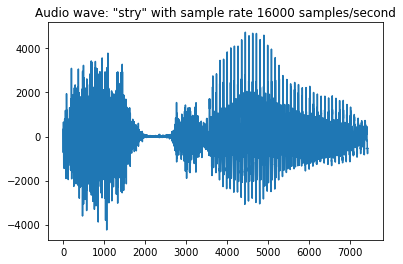

In [6]:
import scipy.io.wavfile
import matplotlib.pyplot as plt

Fs, data = scipy.io.wavfile.read('Audiofiles/stry.wav')
title_string = 'Audio wave: "stry" with sample rate '+ str(Fs) + " samples/second" 
plt.title(title_string)
plt.plot(data)
plt.show()


#### Phoneme characteristics
To be done..

#### The wovel /iy/



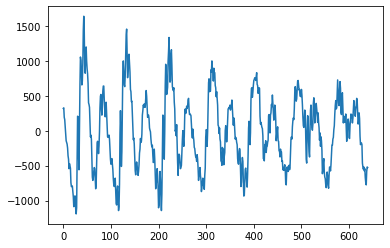

In [2]:
# Assuming that /iy/ is the last 40ms of the signal
import scipy.io.wavfile
import matplotlib.pyplot as plt
Fs, data = scipy.io.wavfile.read('Audiofiles/stry.wav')

desired_time = 40e-3
desired_samples = int(desired_time*Fs)
# We want the last desired_samples of the signal
iy_data = data[len(data)-desired_samples:]

plt.plot(iy_data)


(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the log-spectrum as a function of frequency
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
- Estimate the fundamental frequency $F_0$ using the spectrum, and compare the result to what you got in 1a)
- Roughly estimate the two first formant frequencies.

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the log-spectrum as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?
- Why is it impossible to estimate the fundamental frequency based on the LP model?

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`.

(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjutinf the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

(b) Use the cepstrum to compute the fundamental frequency $F_0$. Compare your results with those obtained in problem 1).

(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.